In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

# Questions 
1. identify level for each employee
2. identify how many people each employee manages
3. a model to predict salary
4. main factors affecting salary? is there bias?

load data

In [2]:
company = pd.read_csv("company_hierarchy.csv")
employee = pd.read_csv("employee.csv")
display(company.head(3))
display(employee.head(3))

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales


,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2


In [3]:
#check out unique for each table
print("Is employee_id unique: {}".format(len(company['employee_id'].unique()) == len(company) == len(employee)))
print("There are {} employees".format(len(company['employee_id'].unique())))

Is employee_id unique: True
There are 10000 employees


In [4]:
#join two tables 
data = pd.merge(employee, company, on='employee_id', how = 'inner')
data.head(3)

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept
0,138719,0,273000.0,Master,M,2,43602.0,engineering
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales
2,114657,0,261000.0,Master,F,2,180854.0,sales


In [5]:
#check out null and some data transformation, we see that there is one
#null value for boss_id, which means this person should be the ceo
data.isnull().sum()

employee_id       0
signing_bonus     0
salary            0
degree_level      0
sex               0
yrs_experience    0
boss_id           1
dept              0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 8 columns):
employee_id       10000 non-null int64
signing_bonus     10000 non-null int64
salary            10000 non-null float64
degree_level      10000 non-null object
sex               10000 non-null object
yrs_experience    10000 non-null int64
boss_id           9999 non-null float64
dept              10000 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 703.1+ KB


## Question 1

In [7]:
#get employee_id for each level of employee
CEO = data[data.dept == 'CEO'].employee_id.unique()
Execu = data[data.boss_id.isin(CEO)].employee_id.unique()
VP = data[data.boss_id.isin(Execu)].employee_id.unique()
Direc = data[data.boss_id.isin(VP)].employee_id.unique()
MM = data[data.boss_id.isin(Direc)].employee_id.unique()
IC = data[data.boss_id.isin(MM)].employee_id.unique()
employees = np.concatenate((IC,MM,Direc, VP, Execu,CEO))
levels = ['IC']*len(IC) + ['MM']*len(MM) + ['D']*len(Direc) + ['VP']*len(VP) + ['E']*len(Execu) + ['CEO']
level_df = pd.DataFrame({"employee_id": employees.astype('int64'), "level": levels})
level_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
employee_id    10000 non-null int64
level          10000 non-null object
dtypes: int64(1), object(1)
memory usage: 156.3+ KB


In [8]:
data = pd.merge(data, level_df, on = 'employee_id', how = 'inner')
data.level.value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

## Question 2

In [9]:
data['num_employee_managed'] = 0
levels = ['IC','MM','D','VP','E']

for level in levels:
    boss_ids = data[data['level'] == level].boss_id
    employee_ids = data[data['level'] == level].employee_id
    for b_id, e_id in zip(boss_ids, employee_ids):
        e_counts = 1 + int(data.loc[data.employee_id == e_id, 'num_employee_managed'])
        b_counts = int(data.loc[data.employee_id == b_id, 'num_employee_managed'])
        data.loc[data.employee_id == b_id, 'num_employee_managed'] = e_counts + b_counts

In [10]:
data[['employee_id','level','num_employee_managed']].sample(10)

,employee_id,level,num_employee_managed
3433,107223,IC,0
5011,20707,IC,0
2864,160213,IC,0
4514,57999,IC,0
6760,122530,IC,0
1855,133748,IC,0
2227,82137,IC,0
2229,42381,IC,0
9360,71569,IC,0
4123,132091,IC,0


## Exploratory data analysis

We see from below:<br\>
1. M:F ~ 6.5:3.5
2. Male has higher percentage of getting a signing bonus than females

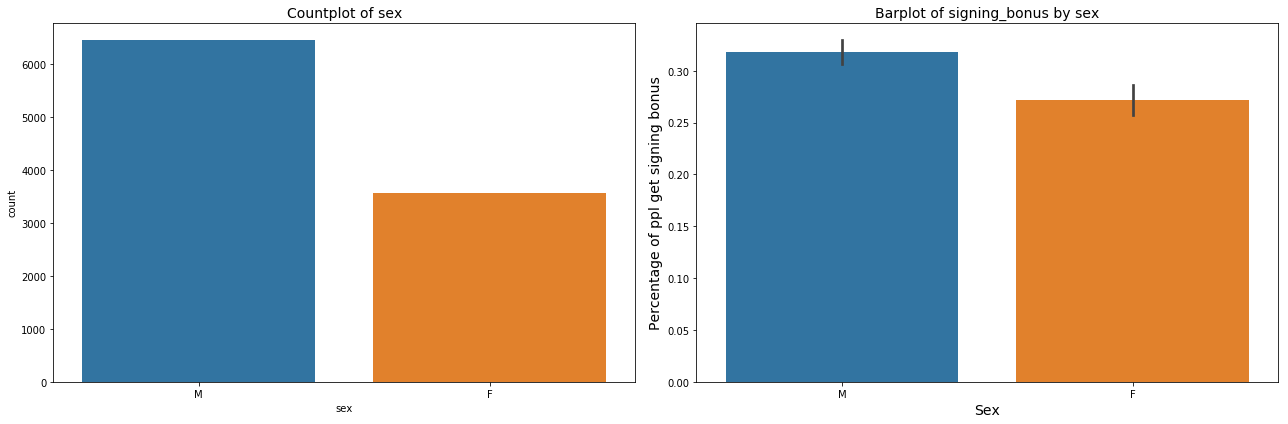

In [11]:
#check out distribution of salary
fig, ax = plt.subplots(nrows = 1,ncols = 2, figsize = (18,6))
sns.countplot(x='sex', data = data, ax = ax[0])
ax[0].set_title("Countplot of sex", fontsize = 14)

sns.barplot(y = 'signing_bonus', data = data, x = 'sex', ax = ax[1])
ax[1].set_title("Barplot of signing_bonus by sex", fontsize = 14)
ax[1].set_ylabel("Percentage of ppl get signing bonus", fontsize = 14)
ax[1].set_xlabel("Sex", fontsize = 14)
plt.tight_layout()

From below plots, we observe: <br\>
1. For salary, there is a long tail distribution for female
2. Degree level doesn't seem to have a much heavy influence on salary level

C:\Users\sz\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


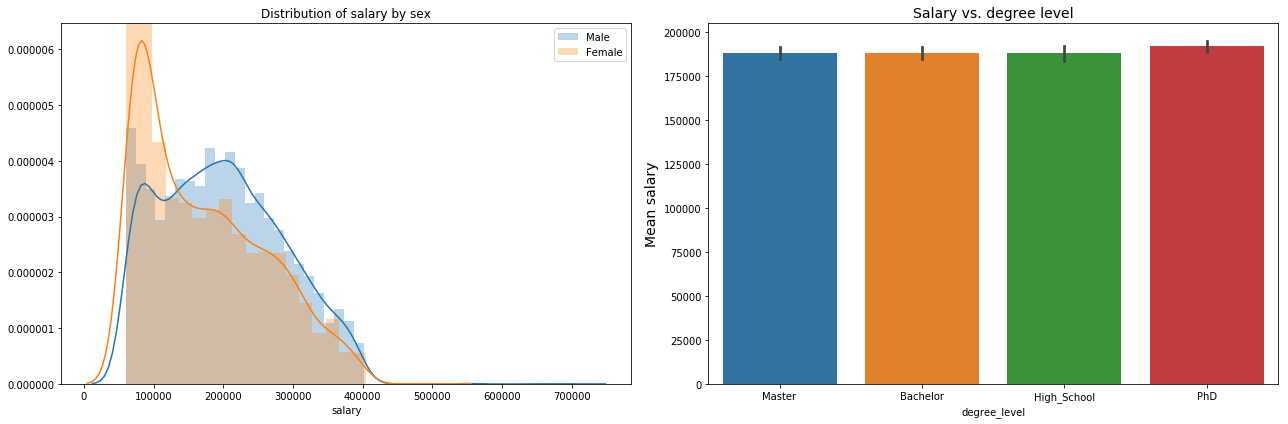

In [12]:
#take a look at the effect of sex and degree on salary
fig, ax = plt.subplots(nrows = 1,ncols =  2, figsize=(18,6))
hist_kws={"alpha": 0.3}

sns.distplot(a= data[data['sex'] == 'M']['salary'], ax = ax[0], hist_kws= hist_kws)
sns.distplot(a = data[data['sex'] == 'F']['salary'], ax = ax[0], hist_kws= hist_kws)
ax[0].legend(['Male', 'Female'])
ax[0].set_title("Distribution of salary by sex")

sns.barplot(x = 'degree_level', y ='salary', data=data, ax = ax[1])
ax[1].set_title("Salary vs. degree level", fontsize = 14)
ax[1].set_ylabel("Mean salary", fontsize = 14)
plt.tight_layout()

From below plots, we observe: <br\>
1. Most of employess have less than 10 yrs experience
2. Experience doesn't have huge impact on salary when it < 13, but there is a sizable increase in salary after 13 yrs exp

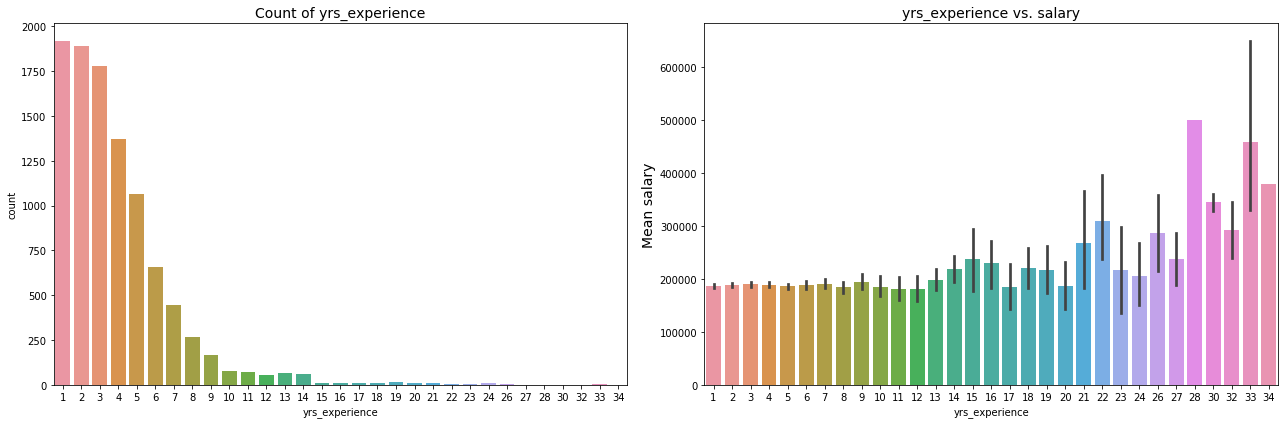

In [13]:
#look at the effect of experience
fig, ax = plt.subplots(nrows = 1,ncols =  2, figsize=(18,6))
sns.countplot(x = 'yrs_experience', data = data, ax=ax[0])
ax[0].set_title("Count of yrs_experience", fontsize = 14)

sns.barplot(x = 'yrs_experience', y ='salary',data=data, ax=ax[1])
ax[1].set_title("yrs_experience vs. salary", fontsize = 14)
ax[1].set_ylabel("Mean salary", fontsize = 14)
plt.tight_layout()

From below plots, we observe:<br\>
1. The effect of dept on salary is very significant. More technical dept(engineering) earns much more than other non-technical ones
2. The effect of level on salary is also significant. High level earns more salary

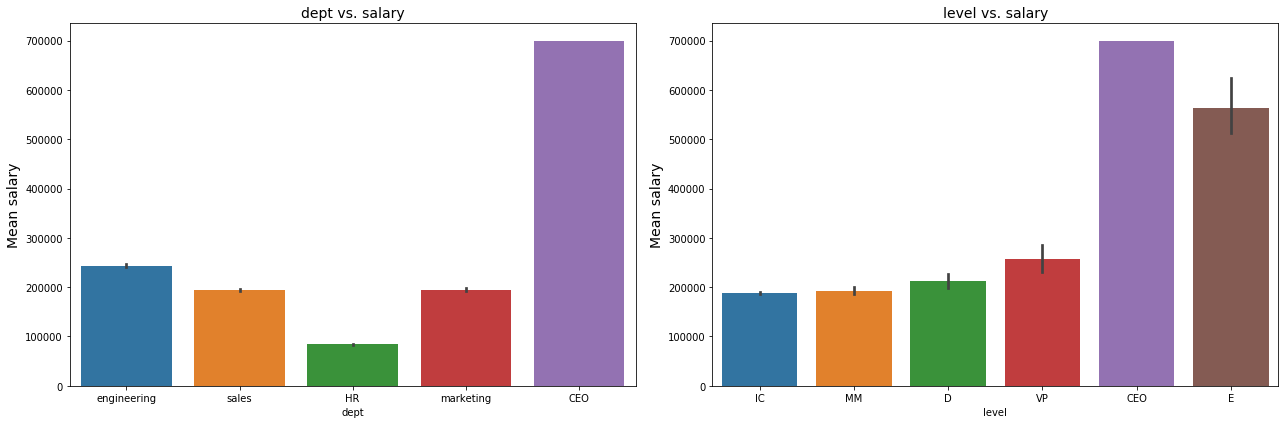

In [14]:
#look at the effect of dept and level on salary
fig, ax = plt.subplots(nrows = 1,ncols = 2,figsize=(18,6))

sns.barplot(x = 'dept', y ='salary',data= data,ax= ax[0])
ax[0].set_title("dept vs. salary", fontsize = 14)
ax[0].set_ylabel("Mean salary", fontsize = 14)

sns.barplot(x = 'level', y ='salary', data = data, ax=ax[1])
ax[1].set_title("level vs. salary", fontsize = 14)
ax[1].set_ylabel("Mean salary", fontsize = 14)
plt.tight_layout()

## Question 3

In [15]:
#drop 3 useless columns, since num_employee_managed is incorporated by level, we remove it
to_drop = ['employee_id', 'boss_id', 'num_employee_managed']
data.drop(to_drop, axis= 1, inplace = True)

#drop CEO since it is an outlier
data = data[data['level'] != 'CEO']

In [16]:
#convert string to numerics, and then categorize
for col in ['degree_level', 'sex','level']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    #data[col] = data[col].astype('category')
data['dept'] = data['dept'].astype('category')

In [17]:
data = pd.get_dummies(data)

In [18]:
data.head(3)

,signing_bonus,salary,degree_level,sex,yrs_experience,level,dept_HR,dept_engineering,dept_marketing,dept_sales
0,0,273000.0,2,1,2,2,0,1,0,0
1,0,301000.0,0,0,1,2,0,0,0,1
2,0,261000.0,2,0,2,2,0,0,0,1


In [19]:
#train test split
from sklearn.model_selection import train_test_split
X, y = data.drop('salary', axis = 1), data['salary']
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 23)

C:\Users\sz\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


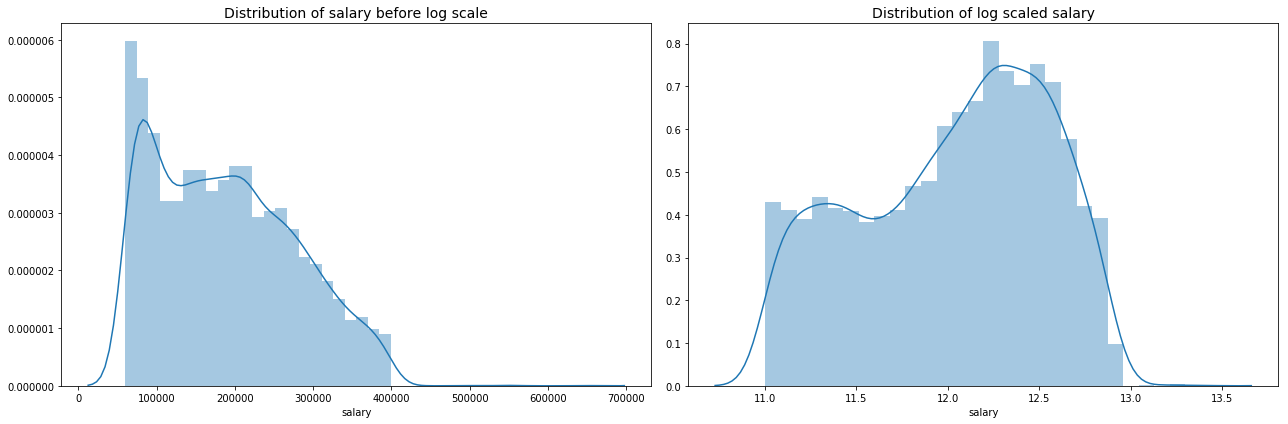

In [20]:
fig, ax = plt.subplots(nrows = 1,ncols = 2, figsize=(18,6))
sns.distplot(a=y_train, ax = ax[0])
ax[0].set_title("Distribution of salary before log scale", fontsize = 14)
sns.distplot(a = np.log(y_train), ax = ax[1])
ax[1].set_title("Distribution of log scaled salary", fontsize = 14)
plt.tight_layout()

In [21]:
#because y is heavily skewed, transform it to log scale
y_train, y_test = np.log(y_train), np.log(y_test)

In [22]:
#use xgboost model
import xgboost as xgb

train = xgb.DMatrix(x_train, y_train)
test = xgb.DMatrix(x_test)

xgb_params = {"objective":"reg:linear", "eval_metric":"rmse", 
             "num_rounds": 200, "early_stopping_rounds": 20, "eta":0.1,
             "subsample":0.8}
cv_results = xgb.cv(xgb_params, train, num_boost_round=xgb_params['num_rounds'], nfold = 5,
                   metrics = xgb_params['eval_metric'], early_stopping_rounds=xgb_params['early_stopping_rounds'],
                   seed = 42, verbose_eval = False)

In [23]:
print("Best round: {}".format(len(cv_results)))

Best round: 62


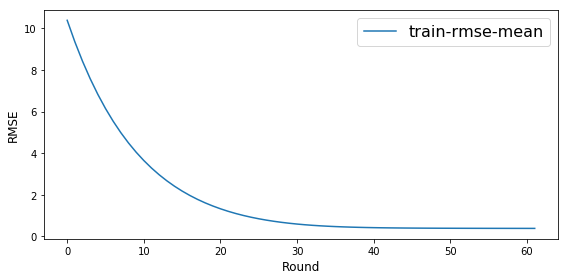

In [24]:
#visualize rmse
fig, ax= plt.subplots(figsize = (8,4))
ax.plot(cv_results['train-rmse-mean'])
ax.set_xlabel('Round', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.legend(fontsize=16)
plt.tight_layout()

In [25]:
#now make predictions
from sklearn.metrics import mean_squared_error, r2_score

clf = xgb.train(xgb_params, train, num_boost_round=len(cv_results))
pred = clf.predict(test)

In [26]:
print("RMSE: {:.3F}".format(mean_squared_error(y_test, pred)))
print("R2: {:.3f}".format(r2_score(y_test, pred)))

RMSE: 0.153
R2: 0.423


## Question 4

Based on below feature importance plot, we see that **yrs_experience** and **degree_level** definitely matters 

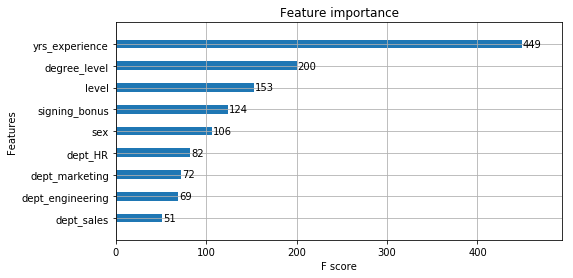

In [27]:
# feature importance
fig, ax = plt.subplots(figsize= (8,4))
xgb.plot_importance(clf, ax = ax, height = 0.4)